In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from odc.geo.xr import ODCExtensionDa
from odc.geo import GeoboxTiles

In [3]:
i = 0; j = 2

# Load data
parquet_tile = pd.read_parquet(f"/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/assembled/_modis.parquet/ix={i}/iy={j}/data.parquet")
land_mask = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_2/osm/land_mask.zarr", consolidated = False)

# Create tiles
tile_size = (2048, 2048)
tile = GeoboxTiles(land_mask.odc.geobox, tile_size)[i,j]

# Add pixel ID information for tile
pixel_id_matrix = xr.DataArray(np.flip(np.arange(tile_size[0] * tile_size[1], dtype="int32").reshape(tile_size), 0), name = 'pixel_id')

In [7]:
test = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/eog/viirs/processed/stage_2/viirs_annual_timeseries_reprojected.zarr", consolidated=False)

In [15]:
tile.coords["latitude"]

Coordinate(values=array([75.     , 74.99583, 74.99166, ..., 66.47235, 66.46818, 66.46401],
      shape=(2048,)), units='degrees_north', resolution=-0.0041700000000020054)

In [21]:
test.sel(
    longitude=slice(tile.coords["longitude"].values[0], tile.coords["longitude"].values[-1]),
    latitude=slice(tile.coords["latitude"].values[0], tile.coords["latitude"].values[-1])
    ).compute()

<xarray.Dataset> Size: 336MB
Dimensions:       (time: 10, band: 1, latitude: 2049, longitude: 2048)
Coordinates:
  * longitude     (longitude) float64 16kB -162.9 -162.9 ... -154.4 -154.4
  * latitude      (latitude) float64 16kB 75.0 75.0 74.99 ... 66.47 66.47 66.47
  * band          (band) int64 8B 1
  * time          (time) datetime64[ns] 80B 2012-12-31 2013-12-31 ... 2021-12-31
Data variables:
    spatial_ref   uint16 2B 0
    viirs_annual  (time, band, latitude, longitude) float64 336MB 0.0 ... 0.0

In [10]:
test.isel(time=5, latitude=slice(5000, 6000), longitude=slice(5000,6000)).viirs_annual.compute()

<xarray.DataArray 'viirs_annual' (band: 1, latitude: 1000, longitude: 1000)> Size: 8MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], shape=(1, 1000, 1000))
Coordinates:
  * longitude  (longitude) float64 8kB -159.2 -159.2 -159.2 ... -155.0 -155.0
  * latitude   (latitude) float64 8kB 54.17 54.16 54.16 ... 50.01 50.01 50.0
  * band       (band) int64 8B 1
    time       datetime64[ns] 8B 2017-12-31

In [4]:
(parquet_tile["viirs_annual"] == 0).mean()

np.float64(0.0)

In [6]:
(parquet_tile["ntl_harm"] == 0).mean()

np.float64(0.9663673152926747)

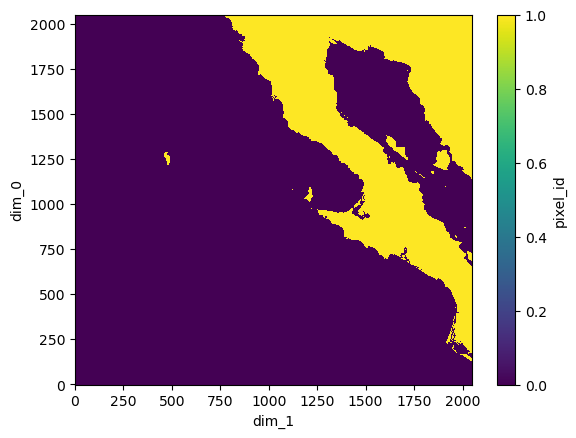

In [4]:
pixel_id_matrix.isin(parquet_tile.pixel_id.unique()).plot.imshow()

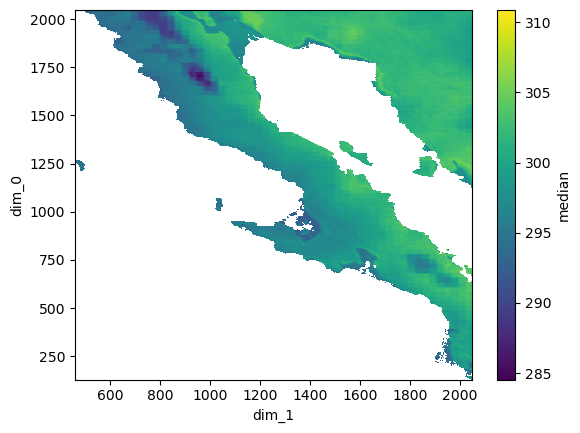

In [7]:
pd.merge(
    parquet_tile.query("year==2000&median>0")[["pixel_id", "median"]], 
    pixel_id_matrix.to_dataframe().reset_index()).set_index(["dim_0", "dim_1"]).to_xarray()["median"].plot.imshow()

In [10]:
parquet_tile.columns

Index(['latitude', 'longitude', 'band', 'year', 'median', 'mean', 'rollmax3',
       'viirs_annual', 'ntl_harm', 'countries', 'subdivisions', 'pixel_id',
       'tile_ix', 'tile_iy', 'median_time_demeaned', 'mean_time_demeaned',
       'rollmax3_time_demeaned', 'viirs_annual_time_demeaned',
       'ntl_harm_time_demeaned', 'median_unit_demeaned', 'mean_unit_demeaned',
       'rollmax3_unit_demeaned', 'viirs_annual_unit_demeaned',
       'ntl_harm_unit_demeaned', 'median_twoway_demeaned',
       'mean_twoway_demeaned', 'rollmax3_twoway_demeaned',
       'viirs_annual_twoway_demeaned', 'ntl_harm_twoway_demeaned'],
      dtype='object')

In [14]:
parquet_tile[["pixel_id", "year", "median", "median_unit_demeaned", "median_time_demeaned", "median_twoway_demeaned"]]

,pixel_id,year,median,median_unit_demeaned,median_time_demeaned,median_twoway_demeaned
16191,771,2000,292.58,0.087619,7.099314,-285.393067
16192,771,2001,291.03,-1.462381,7.898096,-284.594285
16193,771,2002,297.71,5.217619,13.762821,-278.729560
16194,771,2003,293.64,1.147619,9.637784,-282.854597
16195,771,2004,295.67,3.177619,12.006771,-280.485610
...,...,...,...,...,...,...
82532347,3930111,2016,297.97,0.438571,13.351215,-284.180213
82532348,3930111,2017,297.55,0.018571,13.352830,-284.178598
82532349,3930111,2018,297.62,0.088571,13.427046,-284.104383
82532350,3930111,2019,297.54,0.008571,13.077412,-284.454016


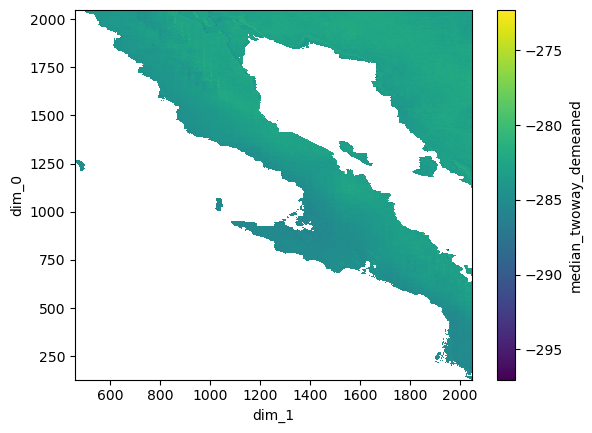

In [8]:
pd.merge(
    parquet_tile.query("year==2000&median>0")[["pixel_id", "median_twoway_demeaned"]], 
    pixel_id_matrix.to_dataframe().reset_index()).set_index(["dim_0", "dim_1"]).to_xarray()["median_twoway_demeaned"].plot.imshow()